# **Problem Statement:**

The project is about on world's largest taxi company Uber inc. In this project we're looking to predict the price for their future transactional cases. UBER deliever services to lakhs of customers daily and it becomes really important to manage their data properly to come up with new business ideas to get best results. So, it becomes really important to estimate the fare prices accurately.



# **Objective:**

Create a robust machine learning model to accurately predict ride charges, enabling the transport company to streamline pricing strategies and offer competitive prices.

# **About Dataset:**

key: Unique trip identifier.

fare_amount: Cost of trip (in USD).

pickup_datetime: Timestamp of trip start.

passenger_count: Number of passengers.

pickup_longitude & pickup_latitude: Initial pickup co-ordinates.

dropoff_longitude & dropoff_latitude: Drop-off co-ordinates.

# Load the libraries

In [1]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform
from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from google.colab import drive
import pickle
import joblib
from optuna import Trial
import optuna


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Load the dataset

In [3]:
url = 'https://raw.githubusercontent.com/Sandip029/UBER_Ride_Price_Prediction/main/uber.csv'

df = pd.read_csv(url)

In [4]:
df.shape

(200000, 9)

# Looking into the data

In [5]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,52:06.0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,47:00.0,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [7]:
df.isnull().sum()

,0
Unnamed: 0,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [8]:
df.nunique()

,0
Unnamed: 0,200000
key,3600
fare_amount,1240
pickup_datetime,196629
pickup_longitude,71014
pickup_latitude,83773
dropoff_longitude,76836
dropoff_latitude,90526
passenger_count,8


In [9]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967153,40.767158,-73.963659,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


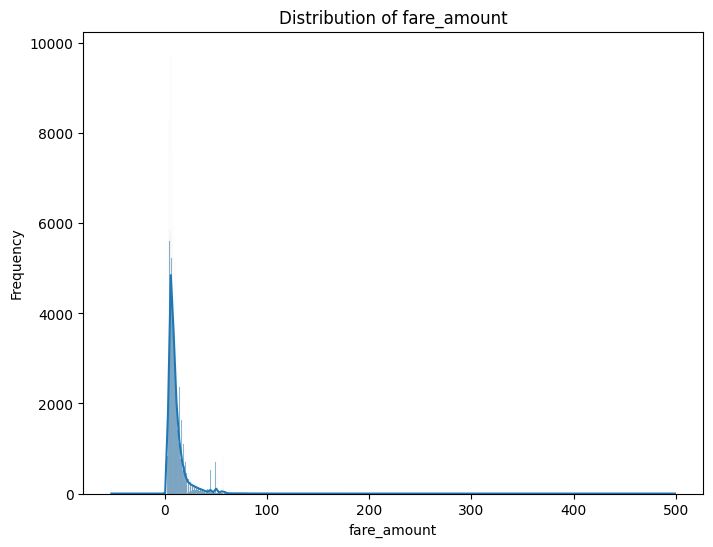

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(df['fare_amount'], kde=True)
plt.title('Distribution of fare_amount')
plt.xlabel('fare_amount')
plt.ylabel('Frequency')
plt.show()

# Apply stratified sampling

In [11]:
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']
y = y.astype(float)

In [12]:
desired_sample_size = 70000
data = pd.concat([X, y], axis=1)

important_data = data[data['fare_amount'] > 150]
remaining_sample_size = desired_sample_size - len(important_data)
remaining_sample_size = max(remaining_sample_size, 0)

remaining_data = data[data['fare_amount'] <= 150]
frac = remaining_sample_size / len(remaining_data)
sampled_remaining_data = remaining_data.groupby('fare_amount', group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42))

In [13]:
sampled_data = pd.concat([important_data, sampled_remaining_data])

sampled_data = sampled_data.sample(n=desired_sample_size, random_state=42) if len(sampled_data) > desired_sample_size else sampled_data

In [14]:
sampled_data.shape

(69852, 9)

In [15]:
new_df= sampled_data.copy()
new_df.head()

,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
4292,33491441,20:00.0,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.000000,3,350.00
18415,11328919,28:11.0,2012-07-29 08:28:11 UTC,-73.797236,40.665420,-73.101445,40.812208,1,190.00
19509,38458832,07:53.0,2015-06-14 19:07:53 UTC,-73.567558,41.047142,-73.567596,41.047127,1,180.00
23682,38390943,40:20.0,2014-11-02 22:40:20 UTC,-73.782161,40.644601,-74.449079,40.836457,1,206.38
29261,5471406,36:11.0,2013-09-27 12:36:11 UTC,-73.801147,40.671653,-73.790402,40.646742,1,220.00


# Feature Engineering

## Dropping rows with missing values

In [ ]:
sampled_data.dropna(inplace=True)

In [ ]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69851 entries, 4292 to 15935
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         69851 non-null  int64  
 1   key                69851 non-null  object 
 2   pickup_datetime    69851 non-null  object 
 3   pickup_longitude   69851 non-null  float64
 4   pickup_latitude    69851 non-null  float64
 5   dropoff_longitude  69851 non-null  float64
 6   dropoff_latitude   69851 non-null  float64
 7   passenger_count    69851 non-null  int64  
 8   fare_amount        69851 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 5.3+ MB


## Converting pickup_datetime to datetime object

In [ ]:
sampled_data['pickup_datetime'] = pd.to_datetime(sampled_data['pickup_datetime'])

In [ ]:
sampled_data['year'] = sampled_data['pickup_datetime'].dt.year
sampled_data['month'] = sampled_data['pickup_datetime'].dt.month
sampled_data['day'] = sampled_data['pickup_datetime'].dt.day
sampled_data['hour'] = sampled_data['pickup_datetime'].dt.hour
sampled_data['minute'] = sampled_data['pickup_datetime'].dt.minute
sampled_data['day_of_week'] = sampled_data['pickup_datetime'].dt.dayofweek

## Adding new column Rush_Hour

In [ ]:
def is_rush_hour(row):
    hour = row['hour']
    day_of_week = row['day_of_week']
    return 1 if (7 <= hour <= 9 and 0 <= day_of_week <= 4) or (16 <= hour <= 18 and 0 <= day_of_week <= 4) else 0

sampled_data['rush_hour'] = sampled_data.apply(is_rush_hour, axis=1)

## Dropping columns that won't be used

In [ ]:
sampled_data.drop(columns=['key', 'Unnamed: 0', 'pickup_datetime'], inplace=True)

In [ ]:
sampled_data.dtypes

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
fare_amount          float64
year                   int32
month                  int32
day                    int32
hour                   int32
minute                 int32
day_of_week            int32
rush_hour              int64
dtype: object

In [ ]:
sampled_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,minute,day_of_week,rush_hour
4292,0.000000,0.000000,0.000000,0.000000,3,350.00,2014,10,24,20,20,4,0
18415,-73.797236,40.665420,-73.101445,40.812208,1,190.00,2012,7,29,8,28,6,0
19509,-73.567558,41.047142,-73.567596,41.047127,1,180.00,2015,6,14,19,7,6,0
23682,-73.782161,40.644601,-74.449079,40.836457,1,206.38,2014,11,2,22,40,6,0
29261,-73.801147,40.671653,-73.790402,40.646742,1,220.00,2013,9,27,12,36,4,0


## Dropping rows that won't be used

In [ ]:
sampled_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,minute,day_of_week,rush_hour
count,69851.000000,69851.000000,69851.000000,69851.000000,69851.000000,69851.000000,69851.000000,69851.00000,69851.000000,69851.000000,69851.000000,69851.000000,69851.000000
mean,-72.536824,39.944710,-72.514705,39.927906,1.684199,11.309047,2011.750841,6.27845,15.668824,13.493479,29.521166,3.038768,0.220297
std,11.300448,7.853238,11.331912,7.209304,1.305474,10.090788,1.858223,3.44066,8.706757,6.498841,17.386615,1.947555,0.414450
min,-736.400000,-74.010777,-75.458979,-881.985513,0.000000,-52.000000,2009.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-73.992131,40.734734,-73.991392,40.733924,1.000000,6.000000,2010.000000,3.00000,8.000000,9.000000,14.000000,1.000000,0.000000
50%,-73.981850,40.752568,-73.980148,40.753052,1.000000,8.500000,2012.000000,6.00000,16.000000,14.000000,29.000000,3.000000,0.000000
75%,-73.967175,40.767149,-73.963772,40.768064,2.000000,12.500000,2013.000000,9.00000,23.000000,19.000000,45.000000,5.000000,0.000000
max,57.418457,1292.016128,1153.572603,493.533332,6.000000,499.000000,2015.000000,12.00000,31.000000,23.000000,59.000000,6.000000,1.000000


**NOTE** : **fare_amount** has the min value as -52 which is not possible. So, we're going to handle all the negative values for **fare_amount**.

In [ ]:
negative_fares = sampled_data[sampled_data['fare_amount'] <= 0]
num_negative_fares = negative_fares.shape[0]

print(f'The number of fare_amount values less than or equal to 0: {num_negative_fares}')

The number of fare_amount values less than or equal to 0: 5


**Dropping those rows where fare_amount value is less than or equal to 0**

In [ ]:
sampled_data = sampled_data[sampled_data['fare_amount'] > 0]

sampled_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,minute,day_of_week,rush_hour
4292,0.000000,0.000000,0.000000,0.000000,3,350.00,2014,10,24,20,20,4,0
18415,-73.797236,40.665420,-73.101445,40.812208,1,190.00,2012,7,29,8,28,6,0
19509,-73.567558,41.047142,-73.567596,41.047127,1,180.00,2015,6,14,19,7,6,0
23682,-73.782161,40.644601,-74.449079,40.836457,1,206.38,2014,11,2,22,40,6,0
29261,-73.801147,40.671653,-73.790402,40.646742,1,220.00,2013,9,27,12,36,4,0


In [ ]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69846 entries, 4292 to 15935
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_longitude   69846 non-null  float64
 1   pickup_latitude    69846 non-null  float64
 2   dropoff_longitude  69846 non-null  float64
 3   dropoff_latitude   69846 non-null  float64
 4   passenger_count    69846 non-null  int64  
 5   fare_amount        69846 non-null  float64
 6   year               69846 non-null  int32  
 7   month              69846 non-null  int32  
 8   day                69846 non-null  int32  
 9   hour               69846 non-null  int32  
 10  minute             69846 non-null  int32  
 11  day_of_week        69846 non-null  int32  
 12  rush_hour          69846 non-null  int64  
dtypes: float64(5), int32(6), int64(2)
memory usage: 5.9 MB


Also max value of **passenger_count** is 208 which isn't practical. So we're setting the threshold to **6**.

In [ ]:
max_passenger = sampled_data[sampled_data['passenger_count'] > 6]
max_passenger_count = max_passenger.shape[0]

print(f'The number of passenger_count values more than 6: {max_passenger_count}')

The number of passenger_count values more than 6: 0


**Dropping those rows where passenger_count value is more than 6**

In [ ]:
sampled_data = sampled_data[sampled_data['passenger_count'] <= 6]

sampled_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,minute,day_of_week,rush_hour
4292,0.000000,0.000000,0.000000,0.000000,3,350.00,2014,10,24,20,20,4,0
18415,-73.797236,40.665420,-73.101445,40.812208,1,190.00,2012,7,29,8,28,6,0
19509,-73.567558,41.047142,-73.567596,41.047127,1,180.00,2015,6,14,19,7,6,0
23682,-73.782161,40.644601,-74.449079,40.836457,1,206.38,2014,11,2,22,40,6,0
29261,-73.801147,40.671653,-73.790402,40.646742,1,220.00,2013,9,27,12,36,4,0


Checking if the **pickup_longitude**, **pickup_latitude**, **dropoff_longitude** and **dropoff_latitude**	has proper values.

In [ ]:
incorrect_pickup_dropoff = sampled_data[(sampled_data['pickup_longitude'] == 0) & (sampled_data['pickup_latitude'] == 0) & (sampled_data['dropoff_longitude'] == 0) & (sampled_data['dropoff_latitude'] == 0)]
incorrect_pickup_dropoff_count = incorrect_pickup_dropoff.shape[0]

print(f'The number of incorrect co-ordinate values: {incorrect_pickup_dropoff_count}')

The number of incorrect co-ordinate values: 1242


**Drop the incorrect coordinates.**

In [ ]:
sampled_data = sampled_data[~((sampled_data['pickup_longitude'] == 0) & (sampled_data['pickup_latitude'] == 0) & (sampled_data['dropoff_longitude'] == 0) & (sampled_data['dropoff_latitude'] == 0))]

sampled_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,minute,day_of_week,rush_hour
18415,-73.797236,40.665420,-73.101445,40.812208,1,190.00,2012,7,29,8,28,6,0
19509,-73.567558,41.047142,-73.567596,41.047127,1,180.00,2015,6,14,19,7,6,0
23682,-73.782161,40.644601,-74.449079,40.836457,1,206.38,2014,11,2,22,40,6,0
29261,-73.801147,40.671653,-73.790402,40.646742,1,220.00,2013,9,27,12,36,4,0
33911,-73.542097,41.052430,-73.542097,41.052430,2,192.33,2014,3,12,19,12,2,0


In [ ]:
sampled_data.shape

(68604, 13)

## Define a new function to calculate the distance between two co-ordinates in kilometer

In [ ]:
def distance_km(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    km = 6371 * c
    return km

**Calculate the distance and add it as a new feature**

In [ ]:
sampled_data['distance'] = sampled_data.apply(lambda row: distance_km(row['pickup_latitude'], row['pickup_longitude'],
                                                row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [ ]:
sampled_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,minute,day_of_week,rush_hour,distance
18415,-73.797236,40.665420,-73.101445,40.812208,1,190.00,2012,7,29,8,28,6,0,60.851156
19509,-73.567558,41.047142,-73.567596,41.047127,1,180.00,2015,6,14,19,7,6,0,0.003621
23682,-73.782161,40.644601,-74.449079,40.836457,1,206.38,2014,11,2,22,40,6,0,60.100889
29261,-73.801147,40.671653,-73.790402,40.646742,1,220.00,2013,9,27,12,36,4,0,2.914493
33911,-73.542097,41.052430,-73.542097,41.052430,2,192.33,2014,3,12,19,12,2,0,0.000000


# Exploratory Data Analysis

## Calculte the Correlation Matrix

In [ ]:
correlation_matrix = sampled_data.corr()
print(correlation_matrix)

                   pickup_longitude  pickup_latitude  dropoff_longitude  \
pickup_longitude           1.000000        -0.234616           0.283595   
pickup_latitude           -0.234616         1.000000           0.462793   
dropoff_longitude          0.283595         0.462793           1.000000   
dropoff_latitude          -0.312241        -0.358214          -0.913066   
passenger_count            0.000482        -0.005563           0.003548   
fare_amount                0.007103        -0.004083           0.010545   
year                       0.017962        -0.012991           0.013383   
month                     -0.007378         0.003307          -0.003666   
day                        0.010247        -0.007910           0.007456   
hour                      -0.000403        -0.003152           0.001146   
minute                     0.004702        -0.001569          -0.001510   
day_of_week               -0.002202        -0.003476          -0.001254   
rush_hour                

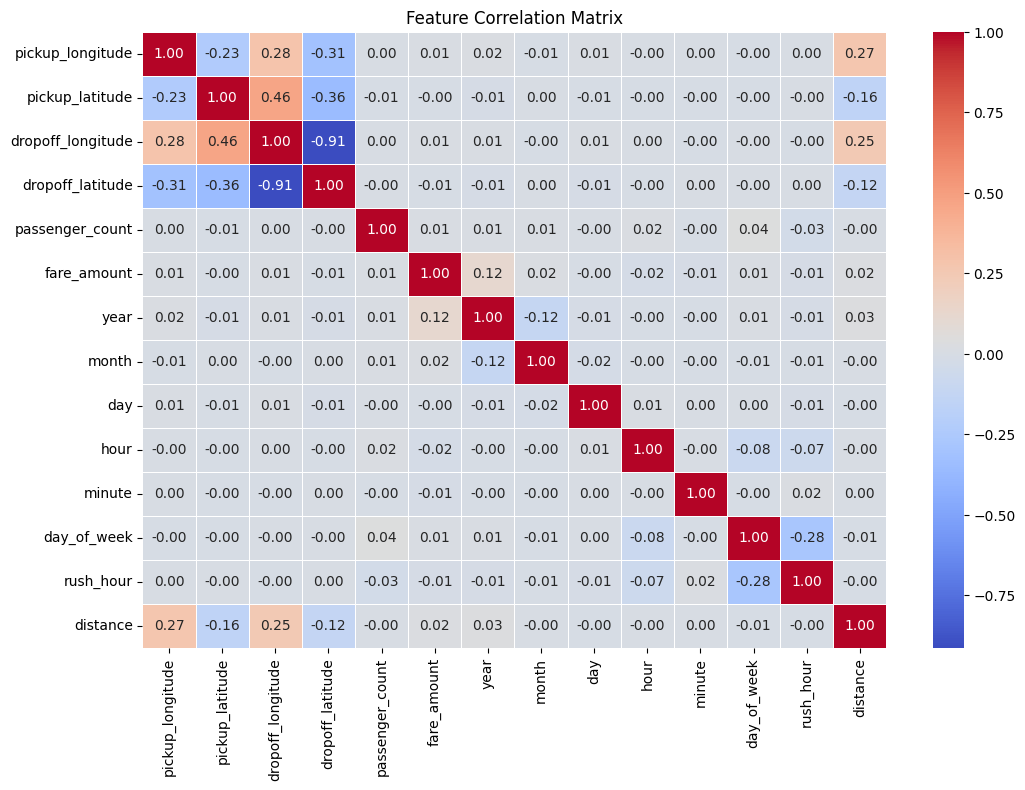

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

**There is high Multicollinearity among the features.**

In [ ]:
!pip install minepy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.0/497.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


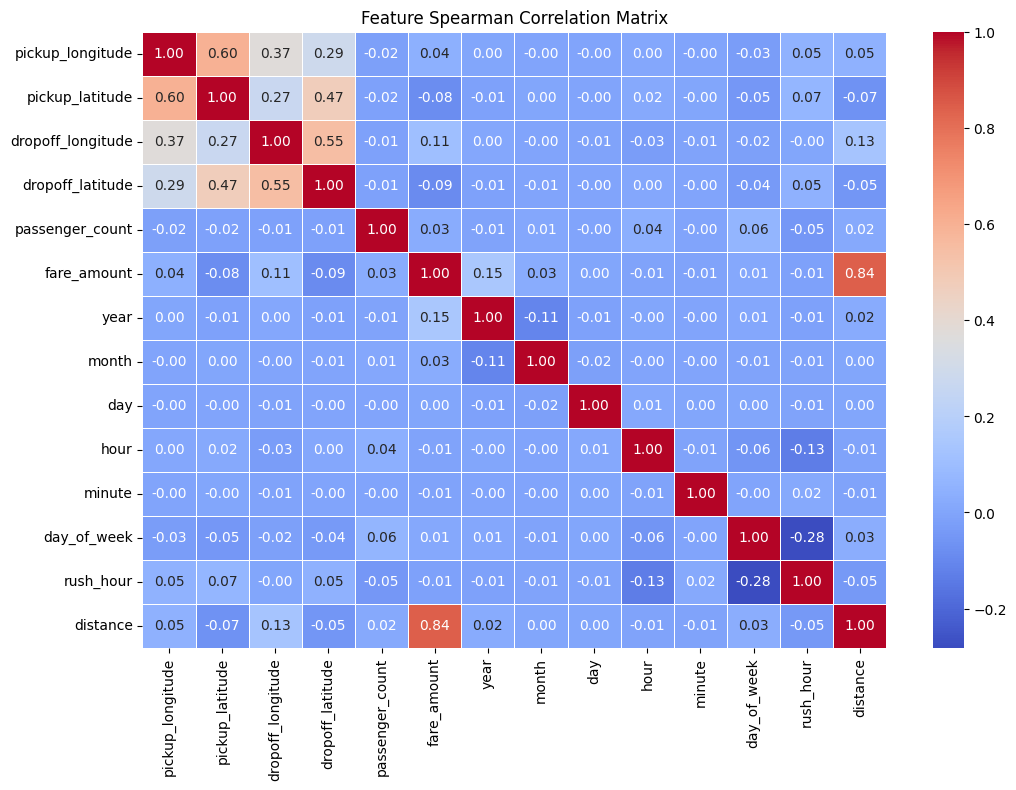

In [ ]:
spearman_corr_matrix = sampled_data.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Spearman Correlation Matrix')
plt.show()

## Define features and target variable

In [ ]:
X = sampled_data.drop(columns=['fare_amount'])
y = sampled_data['fare_amount']
y = y.astype(float)

if y.isnull().any():
    print("NaNs found in y_resampled and dropped.")
    X = X[~y.isnull()]
    y = y.dropna()

In [ ]:
X.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_of_week,rush_hour,distance
count,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000,68604.000000
mean,-73.850997,40.668400,-73.829554,40.651883,1.684435,2011.749534,6.278949,15.675369,13.492012,29.509227,3.038365,0.220133,21.032689
std,5.741145,5.775873,5.802199,4.846214,1.305808,1.860722,3.441716,8.708251,6.498870,17.392749,1.947629,0.414339,384.484069
min,-736.400000,-74.010777,-75.458979,-881.985513,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-73.992307,40.736185,-73.991565,40.735283,1.000000,2010.000000,3.000000,8.000000,9.000000,14.000000,1.000000,0.000000,1.260257
50%,-73.982108,40.753279,-73.980552,40.753680,1.000000,2012.000000,6.000000,16.000000,14.000000,29.000000,3.000000,0.000000,2.166980
75%,-73.968255,40.767522,-73.965366,40.768342,2.000000,2013.000000,9.000000,23.000000,19.000000,45.000000,5.000000,0.000000,3.915607
max,57.418457,1292.016128,1153.572603,493.533332,6.000000,2015.000000,12.000000,31.000000,23.000000,59.000000,6.000000,1.000000,10321.507661


In [ ]:
y.describe()

count    68604.000000
mean        11.298211
std          9.906739
min          0.010000
25%          6.000000
50%          8.500000
75%         12.500000
max        499.000000
Name: fare_amount, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Combine pick-up and drop-off coordinates and use PCA

In [ ]:
coords_train = X_train[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values
pca = PCA(n_components=2)
pca_coords_train = pca.fit_transform(coords_train)

X_train['pca_1'] = pca_coords_train[:, 0]
X_train['pca_2'] = pca_coords_train[:, 1]

coords_test = X_test[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values
pca_coords_test = pca.transform(coords_test)

X_test['pca_1'] = pca_coords_test[:, 0]
X_test['pca_2'] = pca_coords_test[:, 1]

### Calculate the amount of variability retained

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
total_variability_retained = explained_variance_ratio.sum()

print(f"Explained variance ratio for each component: {explained_variance_ratio}")
print(f"Total variability retained: {total_variability_retained:.2f}")

Explained variance ratio for each component: [0.64691103 0.23977165]
Total variability retained: 0.89


## Calculate the Bearing Angle between two points

In [ ]:
def calculate_bearing(lat1, lon1, lat2, lon2):

    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    diff_lon = np.radians(lon2 - lon1)

    x = np.sin(diff_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(diff_lon))

    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

X_train['bearing'] = calculate_bearing(X_train['pickup_latitude'], X_train['pickup_longitude'], X_train['dropoff_latitude'], X_train['dropoff_longitude'])
X_test['bearing'] = calculate_bearing(X_test['pickup_latitude'], X_test['pickup_longitude'], X_test['dropoff_latitude'], X_test['dropoff_longitude'])

**Dropping latitude and longitude columns**

In [ ]:
X_train = X_train.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
X_test = X_test.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [ ]:
X_train.head()

,passenger_count,year,month,day,hour,minute,day_of_week,rush_hour,distance,pca_1,pca_2,bearing
170100,1,2014,2,27,2,54,3,0,1.100734,0.236600,-0.087278,22.080466
98200,1,2014,7,17,22,27,3,0,4.738673,0.186166,0.001274,79.397367
78114,2,2011,12,18,3,58,6,0,0.613689,0.203143,-0.039378,158.698031
177057,1,2012,8,23,21,25,3,0,3.324629,0.212990,-0.017197,42.055397
124736,1,2011,7,15,23,24,4,0,5.044582,0.226871,-0.039273,10.899869


In [ ]:
X_test.head()

,passenger_count,year,month,day,hour,minute,day_of_week,rush_hour,distance,pca_1,pca_2,bearing
32263,2,2013,7,17,21,40,2,0,0.834765,0.224052,-0.061031,197.316321
3217,1,2012,6,12,18,51,1,1,2.572251,0.215006,-0.029479,164.400507
196388,2,2012,5,7,19,13,0,0,5.266040,0.204878,-0.063944,29.744040
192969,2,2013,5,13,14,48,0,0,3.807554,0.222135,-0.070220,183.897546
177381,4,2011,6,24,12,17,4,0,2.135450,0.212808,-0.034400,140.533632


**Recalculate the Correlation Matrix and check for Multicollinearity**

In [ ]:
Train_data = pd.concat([X_train, y_train], axis=1)

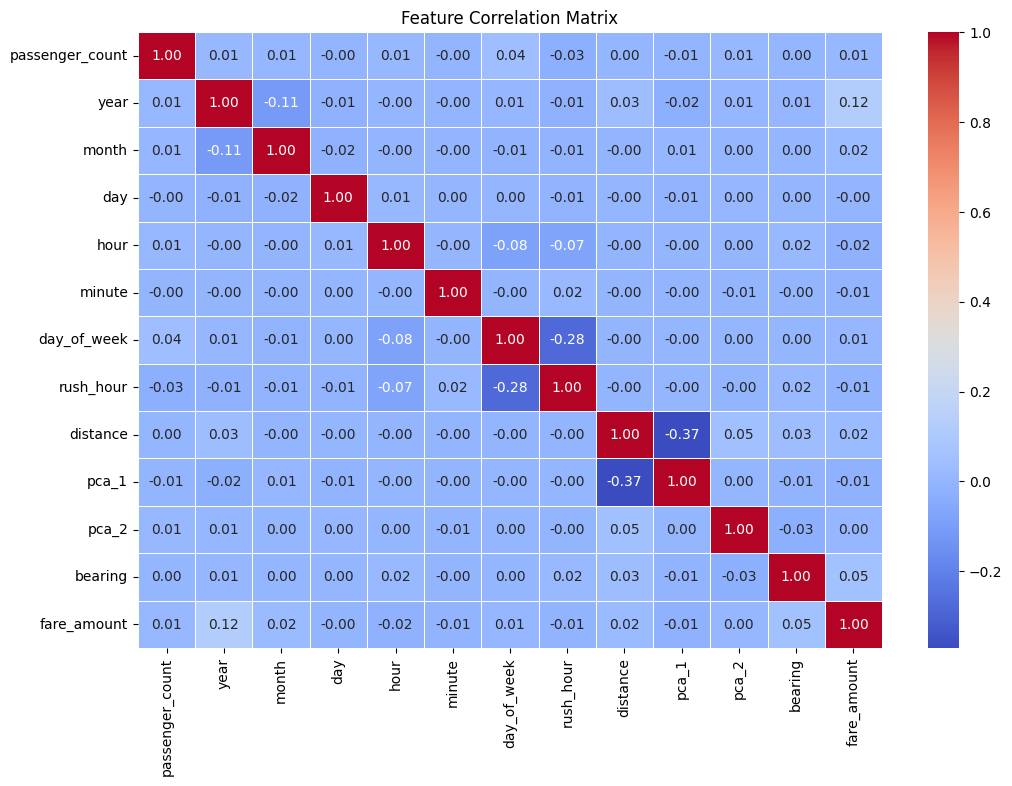

In [ ]:
correlation_matrix = Train_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

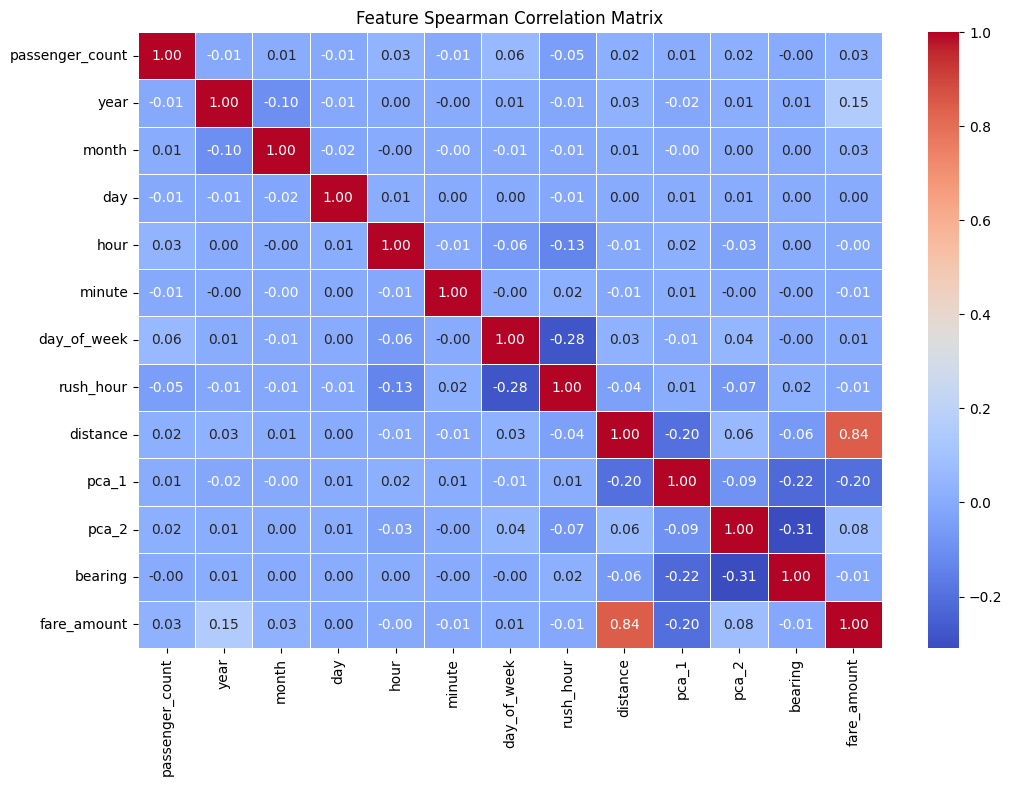

In [ ]:
spearman_corr_matrix = Train_data.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Spearman Correlation Matrix')
plt.show()

# Feature Selection

In [ ]:
fS = SelectKBest(score_func=mutual_info_regression, k=7)
X_new = fS.fit_transform(X_train, y_train)

selected_features_indices = fS.get_support(indices=True)
selected_features = X_train.columns[selected_features_indices]

mutual_info_scores = fS.scores_
mutual_info_series = pd.Series(mutual_info_scores, index=X_train.columns, name='Mutual Information')
mutual_info_sorted = mutual_info_series[selected_features].sort_values(ascending=False)

print(mutual_info_sorted)

distance    0.916684
year        0.456707
pca_1       0.185301
pca_2       0.180384
bearing     0.093111
hour        0.013562
month       0.011433
Name: Mutual Information, dtype: float64


In [ ]:
X_train = X_train[['year', 'month', 'hour', 'distance', 'bearing', 'pca_1', 'pca_2']]
X_test = X_test[['year', 'month', 'hour', 'distance', 'bearing', 'pca_1', 'pca_2']]

# Data distribution of the training and testing data

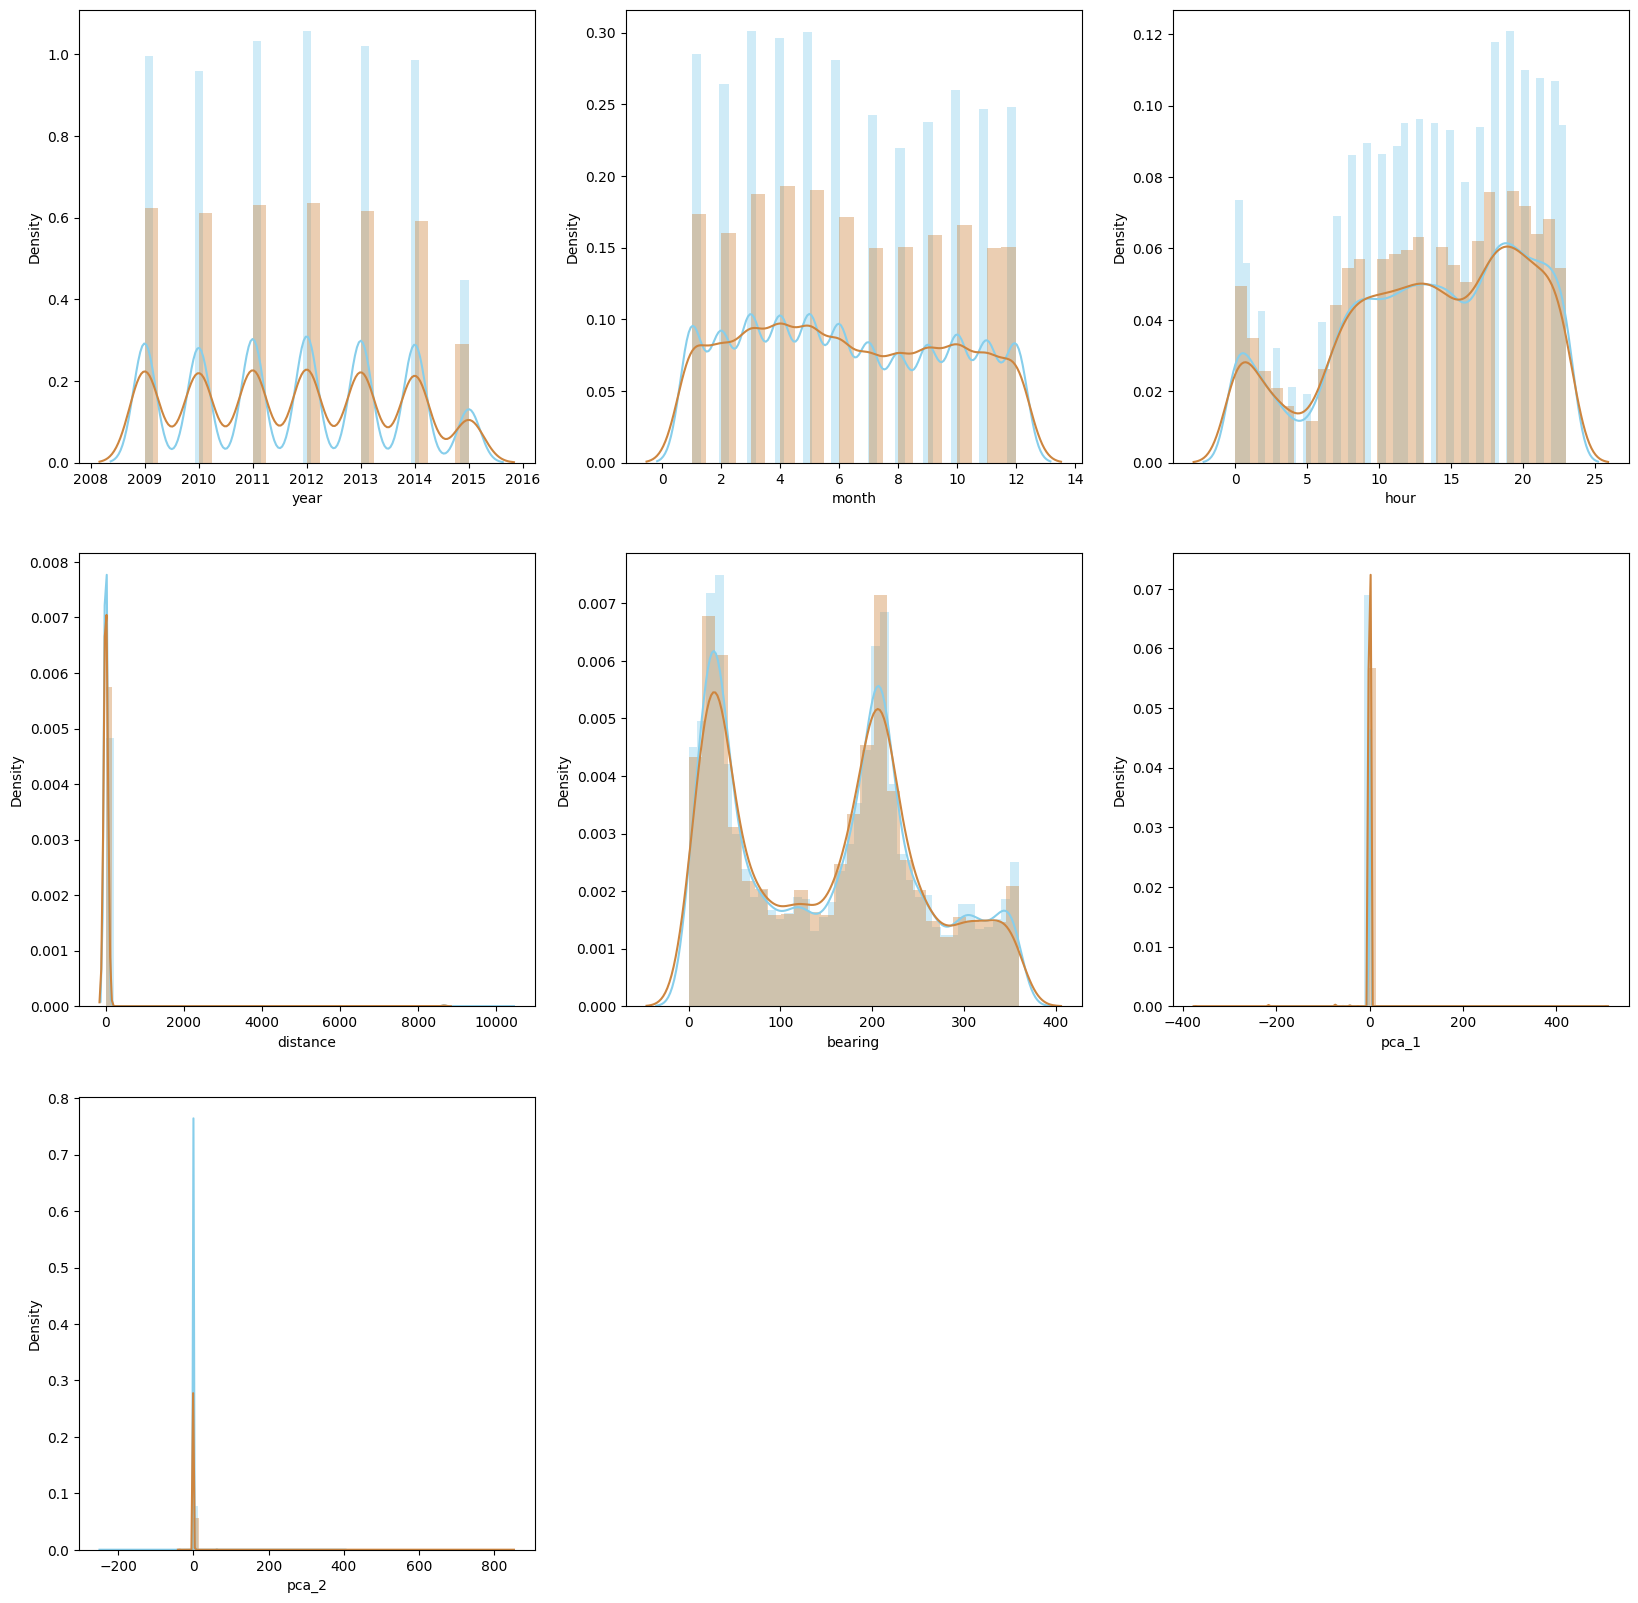

In [ ]:
plt.figure(figsize=(20,20))
for idx in range(7):
  plt.subplot(3,3,idx+1)
  sns.distplot(X_train.iloc[:,idx], color= 'skyblue')
  sns.distplot(X_test.iloc[:, idx], color= 'peru')

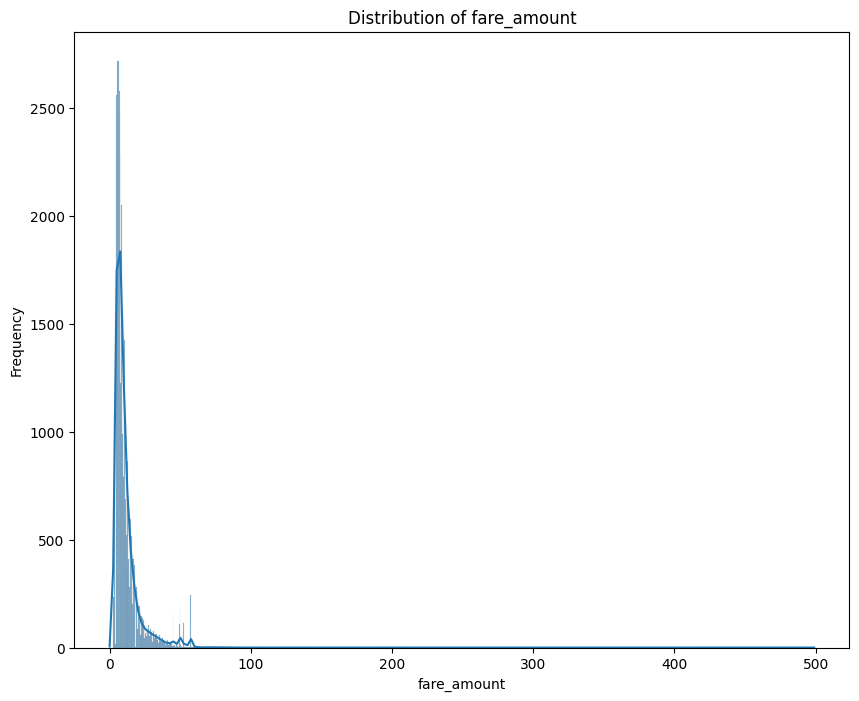

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(y_train, kde=True)
plt.title('Distribution of fare_amount')
plt.xlabel('fare_amount')
plt.ylabel('Frequency')
plt.show()

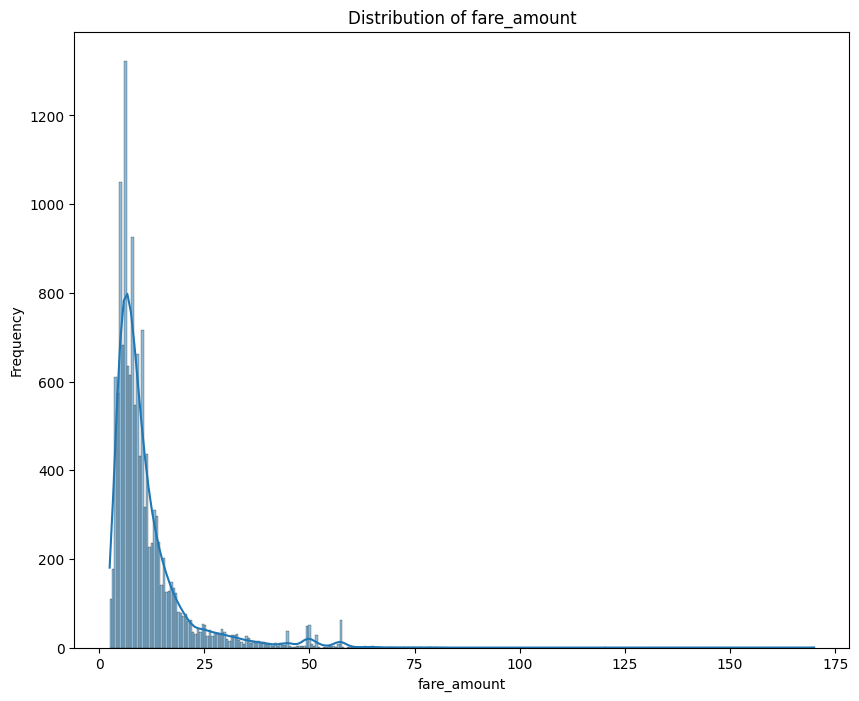

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(y_test, kde=True)
plt.title('Distribution of fare_amount')
plt.xlabel('fare_amount')
plt.ylabel('Frequency')
plt.show()

# Training the Model

## Linear Regression model

### Train the model

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Make predictions


In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

### Evaluate the model

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

Train RMSE: 9.961601617392612
Test RMSE: 9.21206385931409
Train R2: 0.018780692291409773
Test R2: 0.015279022791495955


**The Performance is not upto the mark suggesting linearity properties isn't met.**

---
**Test RMSE: 9.21206385931409**
---
**Test R2: 0.015279022791495955**
---


---



## Ridge Regression model

### Train the model

In [ ]:
from sklearn.linear_model import Ridge, Lasso

In [ ]:
def objective_ridge(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 10.0)
    }
    model = Ridge(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return score

study_ridge = optuna.create_study(direction='maximize')
study_ridge.optimize(objective_ridge, n_trials=30)

[I 2024-07-18 14:50:51,957] A new study created in memory with name: no-name-70631b23-06d6-4844-b291-d07a3e23bcd1
[I 2024-07-18 14:50:52,182] Trial 0 finished with value: -9.956086353894595 and parameters: {'alpha': 0.3923780266746055}. Best is trial 0 with value: -9.956086353894595.
[I 2024-07-18 14:50:52,498] Trial 1 finished with value: -9.956086353652072 and parameters: {'alpha': 0.5512655589302884}. Best is trial 1 with value: -9.956086353652072.
[I 2024-07-18 14:50:52,778] Trial 2 finished with value: -9.956086339590058 and parameters: {'alpha': 9.968317303639083}. Best is trial 2 with value: -9.956086339590058.
[I 2024-07-18 14:50:53,038] Trial 3 finished with value: -9.956086345492054 and parameters: {'alpha': 5.9656788211190745}. Best is trial 2 with value: -9.956086339590058.
[I 2024-07-18 14:50:53,284] Trial 4 finished with value: -9.956086352810223 and parameters: {'alpha': 1.1036942883082017}. Best is trial 2 with value: -9.956086339590058.
[I 2024-07-18 14:50:53,561] Tria

In [ ]:
print("Best parameters for Ridge: ", study_ridge.best_params)

Best parameters for Ridge:  {'alpha': 9.99916189269005}


In [ ]:
ridge_model = Ridge(**study_ridge.best_params, random_state=42)
ridge_model.fit(X_train, y_train)

Ridge(alpha=9.99916189269005, random_state=42)

### Make predictions

In [ ]:
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)

### Evaluate the model

In [ ]:
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2_ridge = r2_score(y_train, y_pred_train)
test_r2_ridge = r2_score(y_test, y_pred_test)

print(f'Ridge Regression - Train RMSE: {train_rmse_ridge}')
print(f'Ridge Regression - Test RMSE: {test_rmse_ridge}')
print(f'Ridge Regression - Train R2: {train_r2_ridge}')
print(f'Ridge Regression - Test R2: {test_r2_ridge}')

Ridge Regression - Train RMSE: 9.961601617613205
Ridge Regression - Test RMSE: 9.21206240963219
Ridge Regression - Train R2: 0.0187806922479532
Ridge Regression - Test R2: 0.015279332718150296


---
**Test RMSE: 9.21206240963219**
---
**Test R2: 0.015279332718150296**
---


---



## Lasso Regression model

### Train the model

In [ ]:
def objective_lasso(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 10.0)
    }
    model = Lasso(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return score

study_lasso = optuna.create_study(direction='maximize')
study_lasso.optimize(objective_lasso, n_trials=30)

[I 2024-07-18 14:51:00,782] A new study created in memory with name: no-name-67b91bf4-c758-4a9e-9ab3-dce7004b2be6
[I 2024-07-18 14:51:01,438] Trial 0 finished with value: -10.035024796202359 and parameters: {'alpha': 9.662016149193597}. Best is trial 0 with value: -10.035024796202359.
[I 2024-07-18 14:51:01,779] Trial 1 finished with value: -10.002469578675647 and parameters: {'alpha': 1.6407035011540692}. Best is trial 1 with value: -10.002469578675647.
[I 2024-07-18 14:51:02,455] Trial 2 finished with value: -10.03498007346833 and parameters: {'alpha': 9.125990595266273}. Best is trial 1 with value: -10.002469578675647.
[I 2024-07-18 14:51:03,085] Trial 3 finished with value: -10.03499261231505 and parameters: {'alpha': 9.279671271068644}. Best is trial 1 with value: -10.002469578675647.
[I 2024-07-18 14:51:03,802] Trial 4 finished with value: -10.034766324192805 and parameters: {'alpha': 5.836979609922448}. Best is trial 1 with value: -10.002469578675647.
[I 2024-07-18 14:51:04,465]

In [ ]:
print("Best parameters for Lasso: ", study_lasso.best_params)

Best parameters for Lasso:  {'alpha': 0.022153817630238243}


In [ ]:
lasso_model = Lasso(**study_lasso.best_params, random_state=42)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.022153817630238243, random_state=42)

### Make predictions

In [ ]:
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)

### Evaluate the model

In [ ]:
train_rmse_Lasso = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_Lasso = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2_Lasso = r2_score(y_train, y_pred_train)
test_r2_Lasso = r2_score(y_test, y_pred_test)

print(f'Lasso Regression - Train RMSE: {train_rmse_Lasso}')
print(f'Lasso Regression - Test RMSE: {test_rmse_Lasso}')
print(f'Lasso Regression - Train R2: {train_r2_Lasso}')
print(f'Lasso Regression - Test R2: {test_r2_Lasso}')

Lasso Regression - Train RMSE: 9.96161474362903
Lasso Regression - Test RMSE: 9.211719202973951
Lasso Regression - Train R2: 0.018778106417051466
Lasso Regression - Test R2: 0.015352705298335323


---
**Test RMSE: 9.211719202973951**
---
**Test R2: 0.015352705298335323**
---


---



## Random Forest Regressor model

### Train the model

In [ ]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3)
    }
    model = RandomForestRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

[I 2024-07-08 05:46:09,943] A new study created in memory with name: no-name-edf06044-d69b-42d4-afcb-6ba96871eb34
[I 2024-07-08 05:47:45,476] Trial 0 finished with value: -4.932554329170887 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: -4.932554329170887.
[I 2024-07-08 05:50:10,126] Trial 1 finished with value: -4.959828880418407 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: -4.932554329170887.
[I 2024-07-08 05:51:45,989] Trial 2 finished with value: -4.934601425603312 and parameters: {'n_estimators': 150, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: -4.932554329170887.
[I 2024-07-08 05:52:53,991] Trial 3 finished with value: -5.177703725142607 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 

In [ ]:
print(f'Best parameters for Random Forest: {study_rf.best_params}')

Best parameters for Random Forest: {'n_estimators': 450, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}


In [ ]:
rf_model = RandomForestRegressor(**study_rf.best_params, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=450, random_state=42)

### Make predictions

In [ ]:
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

### Evaluate the model

In [ ]:
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2_rf = r2_score(y_train, y_pred_train)
test_r2_rf = r2_score(y_test, y_pred_test)

print(f'Random Forest - Train RMSE: {train_rmse_rf}')
print(f'Random Forest - Test RMSE: {test_rmse_rf}')
print(f'Random Forest - Train R2: {train_r2_rf}')
print(f'Random Forest - Test R2: {test_r2_rf}')

Random Forest - Train RMSE: 3.405120367765819
Random Forest - Test RMSE: 3.750870598395984
Random Forest - Train R2: 0.8853503632301779
Random Forest - Test R2: 0.8367461345220506


---
**Test RMSE: 3.750870598395984**
---
**Test R2: 0.8367461345220506**
---

---



## Gradient Boosting Regressor model

### Train the model

In [ ]:
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    }
    model = GradientBoostingRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return score

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=30)

[I 2024-07-08 07:36:51,067] A new study created in memory with name: no-name-16c522cf-bd8f-48f3-84f5-e3b9edb8e01f
[I 2024-07-08 07:37:34,442] Trial 0 finished with value: -4.816121116611 and parameters: {'n_estimators': 100, 'learning_rate': 0.05376953473040164, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: -4.816121116611.
[I 2024-07-08 07:38:58,774] Trial 1 finished with value: -5.184746653471671 and parameters: {'n_estimators': 300, 'learning_rate': 0.09093917710594301, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: -4.816121116611.
[I 2024-07-08 07:40:14,133] Trial 2 finished with value: -5.264053256535098 and parameters: {'n_estimators': 400, 'learning_rate': 0.16487393353751675, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: -4.816121116611.
[I 2024-07-08 07:42:51,322] Trial 3 finished with value: -5.160749987728995 and parameters: {'n_estimators

In [ ]:
print(f'Best parameters for Gradient Boosting: {study_gb.best_params}')

Best parameters for Gradient Boosting: {'n_estimators': 150, 'learning_rate': 0.038743642942934135, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}


In [ ]:
gb_model = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.038743642942934135, max_depth=4,
                          min_samples_leaf=4, n_estimators=150,
                          random_state=42)

### Make predictions

In [ ]:
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_train_gb))
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_test_gb))
train_r2_gb = r2_score(y_train, y_pred_train_gb)
test_r2_gb = r2_score(y_test, y_pred_test_gb)

print(f'Gradient Boosting - Train RMSE: {train_rmse_gb}')
print(f'Gradient Boosting - Test RMSE: {test_rmse_gb}')
print(f'Gradient Boosting - Train R2: {train_r2_gb}')
print(f'Gradient Boosting - Test R2: {test_r2_gb}')

Gradient Boosting - Train RMSE: 4.158173750138097
Gradient Boosting - Test RMSE: 3.7017485122675935
Gradient Boosting - Train R2: 0.8290327165046967
Gradient Boosting - Test R2: 0.8409941397049214


---
**Test RMSE: 3.7017485122675935**
---
**Test R2: 0.8409941397049214**
---
---



## XGBoost Regressor model

### Train the model

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'max_leaves': trial.suggest_int('max_leaves', 2, 20)
    }
    model = XGBRegressor(**params, random_state=42, verbosity=0)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)

[I 2024-07-19 11:35:53,565] A new study created in memory with name: no-name-14082b8b-76e2-4678-987d-ba7539e25838
[I 2024-07-19 11:35:58,675] Trial 0 finished with value: -4.921780920452937 and parameters: {'n_estimators': 248, 'learning_rate': 0.2801870187661136, 'max_depth': 12, 'min_child_weight': 8.19340732630485, 'reg_lambda': 12.524403559815575, 'subsample': 0.913467948085604, 'max_leaves': 13}. Best is trial 0 with value: -4.921780920452937.
[I 2024-07-19 11:36:00,119] Trial 1 finished with value: -5.164302291232015 and parameters: {'n_estimators': 155, 'learning_rate': 0.0708619037583504, 'max_depth': 6, 'min_child_weight': 9.394664342894167, 'reg_lambda': 2.7037258581641774, 'subsample': 0.8373016095117491, 'max_leaves': 4}. Best is trial 0 with value: -4.921780920452937.
[I 2024-07-19 11:36:03,721] Trial 2 finished with value: -4.924168395415637 and parameters: {'n_estimators': 384, 'learning_rate': 0.2064845513848127, 'max_depth': 20, 'min_child_weight': 0.6904723143255121, 

In [ ]:
print(f'Best parameters for XGBoost: {study_xgb.best_params}')

Best parameters for XGBoost: {'n_estimators': 425, 'learning_rate': 0.03529796254153826, 'max_depth': 9, 'min_child_weight': 8.444816386759047, 'reg_lambda': 2.5386637184981495, 'subsample': 0.86437877777651, 'max_leaves': 19}


In [ ]:
xgb_model = XGBRegressor(**study_xgb.best_params, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03529796254153826,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=19,
             min_child_weight=8.444816386759047, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=425,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Make predictions

In [ ]:
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb = r2_score(y_test, y_pred_test_xgb)

print(f'XGBoost - Train RMSE: {train_rmse_xgb}')
print(f'XGBoost - Test RMSE: {test_rmse_xgb}')
print(f'XGBoost - Train R2: {train_r2_xgb}')
print(f'XGBoost - Test R2: {test_r2_xgb}')

XGBoost - Train RMSE: 4.05885949723199
XGBoost - Test RMSE: 3.7466885848827047
XGBoost - Train R2: 0.8371019887928015
XGBoost - Test R2: 0.8371099696640945


---
**Test RMSE: 3.7466885848827047**
---
**Test R2: 0.8371099696640945**
---

---





## HistGradientBoosting Regressor model

### Train the model

In [ ]:
def objective_hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_iter': trial.suggest_int('max_iter', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 25),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0)
    }
    model = HistGradientBoostingRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return score


study_hgb = optuna.create_study(direction='maximize')
study_hgb.optimize(objective_hgb, n_trials=50)

[I 2024-07-08 05:42:48,868] A new study created in memory with name: no-name-08ac71cc-0f91-413c-9dd4-db846686beb0
[I 2024-07-08 05:42:52,836] Trial 0 finished with value: -4.875911780693775 and parameters: {'learning_rate': 0.0584622518886871, 'max_iter': 244, 'max_depth': 10, 'min_samples_leaf': 8, 'l2_regularization': 0.6697488660265014}. Best is trial 0 with value: -4.875911780693775.
[I 2024-07-08 05:42:58,238] Trial 1 finished with value: -4.891374864067423 and parameters: {'learning_rate': 0.08999111876953991, 'max_iter': 335, 'max_depth': 10, 'min_samples_leaf': 12, 'l2_regularization': 0.45169030484409434}. Best is trial 0 with value: -4.875911780693775.
[I 2024-07-08 05:43:01,723] Trial 2 finished with value: -4.876809217741659 and parameters: {'learning_rate': 0.05837830172558269, 'max_iter': 150, 'max_depth': 9, 'min_samples_leaf': 5, 'l2_regularization': 0.9023236020350885}. Best is trial 0 with value: -4.875911780693775.
[I 2024-07-08 05:43:03,889] Trial 3 finished with va

In [ ]:
print(f'Best parameters for Hist Gradient Boosting: {study_hgb.best_params}')

Best parameters for Hist Gradient Boosting: {'learning_rate': 0.15019890516795564, 'max_iter': 439, 'max_depth': 5, 'min_samples_leaf': 10, 'l2_regularization': 0.30509911648487154}


In [ ]:
hgb_model = HistGradientBoostingRegressor(**study_hgb.best_params, random_state=42)
hgb_model.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=0.30509911648487154,
                              learning_rate=0.15019890516795564, max_depth=5,
                              max_iter=439, min_samples_leaf=10,
                              random_state=42)

### Make predictions

In [ ]:
y_pred_train_hist_gb = hgb_model.predict(X_train)
y_pred_test_hist_gb = hgb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_rmse_hist_gb = np.sqrt(mean_squared_error(y_train, y_pred_train_hist_gb))
test_rmse_hist_gb = np.sqrt(mean_squared_error(y_test, y_pred_test_hist_gb))
train_r2_hist_gb = r2_score(y_train, y_pred_train_hist_gb)
test_r2_hist_gb = r2_score(y_test, y_pred_test_hist_gb)

print(f'Hist Gradient Boosting - Train RMSE: {train_rmse_hist_gb}')
print(f'Hist Gradient Boosting - Test RMSE: {test_rmse_hist_gb}')
print(f'Hist Gradient Boosting - Train R2: {train_r2_hist_gb}')
print(f'Hist Gradient Boosting - Test R2: {test_r2_hist_gb}')

Hist Gradient Boosting - Train RMSE: 4.300833803742884
Hist Gradient Boosting - Test RMSE: 3.762642012502697
Hist Gradient Boosting - Train R2: 0.8171002687375983
Hist Gradient Boosting - Test R2: 0.8357198424653228


---
**Test RMSE: 3.762642012502697**
---
**Test R2: 0.8357198424653228**
---


---





The Model with the best score is **Gradient Boosting: {'n_estimators': 150, 'learning_rate': 0.038743642942934135, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}**
---


---





# Create Pipeline

## Create feature_engineering_pipeline

In [16]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pca = PCA(n_components=2)

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

        X = X.dropna()

        if all(col in X.columns for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']):
            coords = X[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values
            self.pca.fit(coords)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X = X.dropna()
        if all(col in X.columns for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']):
            def distance_km(lon1, lat1, lon2, lat2):
                R = 6371
                dlon = np.radians(lon2 - lon1)
                dlat = np.radians(lat2 - lat1)
                a = (np.sin(dlat/2) ** 2 +
                     np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) ** 2)
                c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
                km = R * c
                return km

            def calculate_bearing(lat1, lon1, lat2, lon2):
                dLon = np.radians(lon2 - lon1)
                lat1 = np.radians(lat1)
                lat2 = np.radians(lat2)
                y = np.sin(dLon) * np.cos(lat2)
                x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dLon)
                bearing = np.degrees(np.arctan2(y, x))
                return (bearing + 360) % 360

            X['distance'] = distance_km(X['pickup_longitude'], X['pickup_latitude'], X['dropoff_longitude'], X['dropoff_latitude'])
            X['bearing'] = X.apply(lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

            coords = X[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values
            pca_coords = self.pca.transform(coords)
            X['pca_1'] = pca_coords[:, 0]
            X['pca_2'] = pca_coords[:, 1]

        return X[['year', 'month', 'hour', 'distance', 'bearing', 'pca_1', 'pca_2']]

In [17]:
feature_engineering = FeatureEngineering()

In [18]:
drive.mount('/content/drive')

with open('/content/drive/My Drive/feature_engineering.pkl', 'wb') as f:
    pickle.dump(feature_engineering, f)

Mounted at /content/drive


In [19]:
with open('/content/drive/My Drive/feature_engineering.pkl', 'rb') as f:
    feature_engineering_pipeline = pickle.load(f)

## Define Model

In [20]:
model = GradientBoostingRegressor(
    learning_rate=0.038743642942934135,
    max_depth=4,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=150,
    random_state=42
)

## Create the prediction pipeline

In [21]:
pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering_pipeline),
    ('model', model)
])

## Create preprocessing_pipeline


In [22]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if 'fare_amount' in X.columns:
            X.dropna(inplace=True)
            X = X[X['fare_amount'] > 0]
            X = X[X['passenger_count'] <= 6]
            X = X[~((X['pickup_longitude'] == 0) & (X['pickup_latitude'] == 0) &
                    (X['dropoff_longitude'] == 0) & (X['dropoff_latitude'] == 0))]

        if 'pickup_datetime' in X.columns:
            X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])
            X['year'] = X['pickup_datetime'].dt.year
            X['month'] = X['pickup_datetime'].dt.month
            X['day'] = X['pickup_datetime'].dt.day
            X['hour'] = X['pickup_datetime'].dt.hour
            X['minute'] = X['pickup_datetime'].dt.minute
            X['day_of_week'] = X['pickup_datetime'].dt.dayofweek
            X.drop(columns=['key', 'Unnamed: 0', 'pickup_datetime'], errors='ignore', inplace=True)

        return X

In [23]:
DataPreprocessing =  DataPreprocessor()

In [24]:
with open('/content/drive/My Drive/preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(DataPreprocessing, f)

## Load the preprocessing_pipeline and dataset

In [25]:
with open('/content/drive/My Drive/preprocessing_pipeline.pkl', 'rb') as f:
    preprocessing_pipeline = pickle.load(f)

In [26]:
df = new_df
df = preprocessing_pipeline.fit_transform(df)

In [27]:
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit the data into the pipeline

In [28]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.038743642942934135,
                                           max_depth=4, min_samples_leaf=4,
                                           n_estimators=150,
                                           random_state=42))])

In [29]:
model = pipeline.named_steps['model']
importances = model.feature_importances_
feature_names = pipeline.named_steps['feature_engineering'].transform(X_train).columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

    feature  importance
3  distance    0.863342
5     pca_1    0.044721
6     pca_2    0.036350
0      year    0.034992
4   bearing    0.013375
2      hour    0.005348
1     month    0.001872


In [30]:
joblib.dump(pipeline, '/content/drive/My Drive/best_pipeline.joblib')

['/content/drive/My Drive/best_pipeline.joblib']

The prediction pipeline is saved as **best_pipeline.joblib** into the Google Drive.

## Model Performance

In [31]:
best_model_path = '/content/drive/My Drive/best_pipeline.joblib'
model_pipeline = joblib.load(best_model_path)

In [32]:
y_pred_train_gb = model_pipeline.predict(X_train)
y_pred_test_gb = model_pipeline.predict(X_test)

train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_train_gb))
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_test_gb))
train_r2_gb = r2_score(y_train, y_pred_train_gb)
test_r2_gb = r2_score(y_test, y_pred_test_gb)

print(f'Gradient Boosting - Train RMSE: {train_rmse_gb}')
print(f'Gradient Boosting - Test RMSE: {test_rmse_gb}')
print(f'Gradient Boosting - Train R2: {train_r2_gb}')
print(f'Gradient Boosting - Test R2: {test_r2_gb}')

Gradient Boosting - Train RMSE: 4.158173750138097
Gradient Boosting - Test RMSE: 3.7017485122675935
Gradient Boosting - Train R2: 0.8290327165046967
Gradient Boosting - Test R2: 0.8409941397049214


# Make new predictions using Streamlit

In [33]:
!pip install streamlit -q
!pip install pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [34]:
%%writefile uber_fare_prediction.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pca = PCA(n_components=2)

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

        X = X.dropna()

        if all(col in X.columns for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']):
            coords = X[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values
            self.pca.fit(coords)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X = X.dropna()
        if all(col in X.columns for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']):
            def distance_km(lon1, lat1, lon2, lat2):
                R = 6371
                dlon = np.radians(lon2 - lon1)
                dlat = np.radians(lat2 - lat1)
                a = (np.sin(dlat/2) ** 2 +
                     np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) ** 2)
                c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
                km = R * c
                return km

            def calculate_bearing(lat1, lon1, lat2, lon2):
                dLon = np.radians(lon2 - lon1)
                lat1 = np.radians(lat1)
                lat2 = np.radians(lat2)
                y = np.sin(dLon) * np.cos(lat2)
                x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dLon)
                bearing = np.degrees(np.arctan2(y, x))
                return (bearing + 360) % 360

            X['distance'] = distance_km(X['pickup_longitude'], X['pickup_latitude'], X['dropoff_longitude'], X['dropoff_latitude'])
            X['bearing'] = X.apply(lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

            coords = X[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values
            pca_coords = self.pca.transform(coords)
            X['pca_1'] = pca_coords[:, 0]
            X['pca_2'] = pca_coords[:, 1]

        return X[['year', 'month', 'hour', 'distance', 'bearing', 'pca_1', 'pca_2']]

class DataPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if 'fare_amount' in X.columns:
            X.dropna(inplace=True)
            X = X[X['fare_amount'] > 0]
            X = X[X['passenger_count'] <= 6]
            X = X[~((X['pickup_longitude'] == 0) & (X['pickup_latitude'] == 0) &
                    (X['dropoff_longitude'] == 0) & (X['dropoff_latitude'] == 0))]

        if 'pickup_datetime' in X.columns:
            X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])
            X['year'] = X['pickup_datetime'].dt.year
            X['month'] = X['pickup_datetime'].dt.month
            X['day'] = X['pickup_datetime'].dt.day
            X['hour'] = X['pickup_datetime'].dt.hour
            X['minute'] = X['pickup_datetime'].dt.minute
            X['day_of_week'] = X['pickup_datetime'].dt.dayofweek
            X.drop(columns=['key', 'Unnamed: 0', 'pickup_datetime'], errors='ignore', inplace=True)

        return X

# Load the dataset
url = 'https://raw.githubusercontent.com/Sandip029/UBER_Ride_Price_Prediction/main/uber.csv'
df = pd.read_csv(url)
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']
y = y.astype(float)
desired_sample_size = 70000
data = pd.concat([X, y], axis=1)
important_data = data[data['fare_amount'] > 150]
remaining_sample_size = desired_sample_size - len(important_data)
remaining_sample_size = max(remaining_sample_size, 0)
remaining_data = data[data['fare_amount'] <= 150]
frac = remaining_sample_size / len(remaining_data)
sampled_remaining_data = remaining_data.groupby('fare_amount', group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42))
df = pd.concat([important_data, sampled_remaining_data])
df = df.sample(n=desired_sample_size, random_state=42) if len(df) > desired_sample_size else df

# Instantiate DataPreprocessor and FeatureEngineering
data_preprocessing = DataPreprocessor()
feature_engineering = FeatureEngineering()

# Preprocess and fit PCA
df_processed = data_preprocessing.fit_transform(df)
feature_engineering.fit(df_processed)

# Load the pipeline
pipeline = joblib.load('/content/drive/My Drive/best_pipeline.joblib')

st.title('UBER Fare Prediction')

passenger_count = st.number_input('Passenger Count', min_value=1, max_value=8, value=1)
year = st.number_input('Year', min_value=2010, max_value=2024, value=2024)
month = st.number_input('Month', min_value=1, max_value=12, value=7)
day = st.number_input('Day', min_value=1, max_value=31, value=19)
hour = st.number_input('Hour', min_value=0, max_value=23, value=8)
minute = st.number_input('Minute', min_value=0, max_value=59, value=28)
pickup_latitude = st.number_input('Pickup Latitude', value=40.665420, format="%.6f")
pickup_longitude = st.number_input('Pickup Longitude', value=-73.797236, format="%.6f")
dropoff_latitude = st.number_input('Dropoff Latitude', value=40.812208, format="%.6f")
dropoff_longitude = st.number_input('Dropoff Longitude', value=-73.101445, format="%.6f")
day_of_week = st.selectbox('Day of the Week', [0, 1, 2, 3, 4, 5, 6], format_func=lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][x])

new_data = pd.DataFrame({
    'passenger_count': [passenger_count],
    'year': [year],
    'month': [month],
    'day': [day],
    'hour': [hour],
    'minute': [minute],
    'pickup_latitude': [pickup_latitude],
    'pickup_longitude': [pickup_longitude],
    'dropoff_latitude': [dropoff_latitude],
    'dropoff_longitude': [dropoff_longitude],
    'day_of_week': [day_of_week]
})

if st.button('Predict Fare'):
    predicted_fare = pipeline.predict(new_data)
    st.markdown(f"""
        <div style="display: flex; justify-content: center; align-items: center; padding: 10px; border: 2px solid #4CAF50; border-radius: 10px; background-color: #f9f9f9; margin-top: 20px;">
            <h2 style="color: #4CAF50;">The predicted fare is: ${predicted_fare[0]:.2f}</h2>
        </div>
    """, unsafe_allow_html=True)

Writing uber_fare_prediction.py


In [35]:
from pyngrok import ngrok
import subprocess

ngrok.set_auth_token("2jhoNI1jfLmSpnrRlJ3hzjinWOz_6D3Wi4PDE4vVZrsYPRBY")
ngrok_tunnel = ngrok.connect(8501)
print("Public URL:", ngrok_tunnel.public_url)

subprocess.Popen(["streamlit", "run", "uber_fare_prediction.py"])

import time
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Ngrok tunnel stopped.")

Public URL: https://6913-34-23-217-234.ngrok-free.app
Ngrok tunnel stopped.
